Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Top 10 keywords for Helpfulness > 0.5: ['dvd' 'film' 'good' 'great' 'just' 'like' 'movie' 'really' 'story' 'time']


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:40:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Stacking Classifier Validation Accuracy: 56.24%


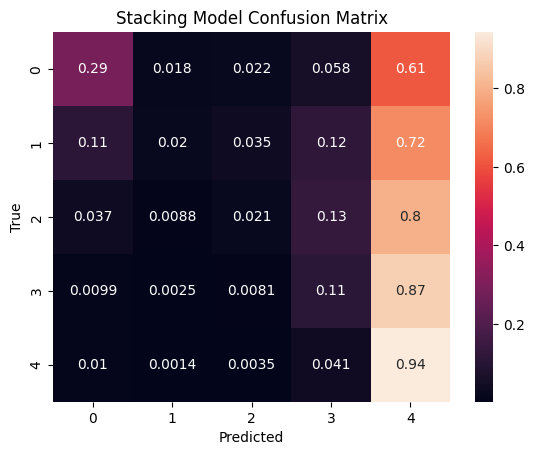

In [2]:
# Import necessary libraries
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load datasets from Google Drive
train_data = pd.read_csv("/content/drive/MyDrive/CS506/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/CS506/test.csv")

# Helper function to calculate helpfulness score
def calculate_helpfulness_score(df):
    df['HelpfulnessScore'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['HelpfulnessScore'] = df['HelpfulnessScore'].fillna(0)  # Replace NaNs with 0
    return df

# Helper function to add keyword features based on text data
def generate_keyword_features(df, top_keywords=10):
    filtered_df = df[df['HelpfulnessScore'] > 0.5]
    vectorizer = CountVectorizer(stop_words='english', max_features=top_keywords)
    keyword_matrix = vectorizer.fit_transform(filtered_df['Text'].dropna().tolist())
    primary_keywords = vectorizer.get_feature_names_out()

    print(f"Top {top_keywords} keywords for Helpfulness > 0.5: {primary_keywords}")

    for word in primary_keywords:
        df[f'contains_{word}'] = df['Text'].apply(lambda x: 1 if pd.notnull(x) and word in x.lower() else 0)

    additional_keywords = ['love', 'great', 'recommend', 'best', 'favorite', 'worst', 'awful', 'terrific']
    for word in additional_keywords:
        df[f'contains_{word}'] = df['Text'].apply(lambda x: 1 if pd.notnull(x) and word in x.lower() else 0)

    all_keywords = list(primary_keywords) + additional_keywords
    return df, all_keywords

# Helper function to add review length feature
def add_review_length_feature(df):
    df['review_length'] = df['Text'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
    return df

# Add custom features to the dataset
def prepare_features(df, keyword_limit=10):
    df = calculate_helpfulness_score(df)
    df, keyword_features = generate_keyword_features(df, top_keywords=keyword_limit)
    df = add_review_length_feature(df)
    return df, keyword_features

# Load processed features if they exist, else create them
if exists('/content/drive/MyDrive/CS506/X_train_features.csv'):
    X_train_features = pd.read_csv("/content/drive/MyDrive/CS506/X_train_features.csv")
if exists('/content/drive/MyDrive/CS506/X_submission_features.csv'):
    X_submission_features = pd.read_csv("/content/drive/MyDrive/CS506/X_submission_features.csv")

else:
    prepared_train, keywords = prepare_features(train_data, keyword_limit=10)
    X_submission_features = pd.merge(prepared_train, test_data, on='Id')
    X_submission_features = X_submission_features.drop(columns=['Score_x']).rename(columns={'Score_y': 'Score'})
    X_train_features = prepared_train[prepared_train['Score'].notnull() & (prepared_train['HelpfulnessScore'] > 0.5)]

    X_submission_features.to_csv("/content/drive/MyDrive/CS506/X_submission_features.csv", index=False)
    X_train_features.to_csv("/content/drive/MyDrive/CS506/X_train_features.csv", index=False)

# Split the training set into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_features.drop(columns=['Score']),
    X_train_features['Score'],
    test_size=1/4.25,
    random_state=0
)

# Define relevant features for training
selected_features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'HelpfulnessScore', 'review_length'] + \
                    [f'contains_{keyword}' for keyword in keywords]

X_train_data = X_train[selected_features]
X_val_data = X_val[selected_features]
X_submission_data = X_submission_features[selected_features]

# Initialize base models
gb_model = GradientBoostingClassifier(n_estimators=50, random_state=42)
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Define cross-validation folds
cv_folds = 3

# Perform cross-validation for each model and collect prediction probabilities
gb_preds = cross_val_predict(gb_model, X_train_data, Y_train, cv=cv_folds, method='predict_proba')
rf_preds = cross_val_predict(rf_model, X_train_data, Y_train, cv=cv_folds, method='predict_proba')
lr_preds = cross_val_predict(lr_model, X_train_data, Y_train, cv=cv_folds, method='predict_proba')

# Stack model predictions for meta-model input
stacked_train_preds = pd.DataFrame({
    'gb_class_1': gb_preds[:, 0],
    'gb_class_2': gb_preds[:, 1],
    'gb_class_3': gb_preds[:, 2],
    'gb_class_4': gb_preds[:, 3],
    'gb_class_5': gb_preds[:, 4],
    'rf_class_1': rf_preds[:, 0],
    'rf_class_2': rf_preds[:, 1],
    'rf_class_3': rf_preds[:, 2],
    'rf_class_4': rf_preds[:, 3],
    'rf_class_5': rf_preds[:, 4],
    'lr_class_1': lr_preds[:, 0],
    'lr_class_2': lr_preds[:, 1],
    'lr_class_3': lr_preds[:, 2],
    'lr_class_4': lr_preds[:, 3],
    'lr_class_5': lr_preds[:, 4]
})

# Initialize the meta-model for stacking
stacking_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
stacking_model.fit(stacked_train_preds, Y_train - 1)

# Train each base model on the full training set
gb_model.fit(X_train_data, Y_train)
rf_model.fit(X_train_data, Y_train)
lr_model.fit(X_train_data, Y_train)

# Predict on the validation set for each base model
gb_val_preds = gb_model.predict_proba(X_val_data)
rf_val_preds = rf_model.predict_proba(X_val_data)
lr_val_preds = lr_model.predict_proba(X_val_data)

# Stack validation set predictions for meta-model
stacked_val_preds = pd.DataFrame({
    'gb_class_1': gb_val_preds[:, 0],
    'gb_class_2': gb_val_preds[:, 1],
    'gb_class_3': gb_val_preds[:, 2],
    'gb_class_4': gb_val_preds[:, 3],
    'gb_class_5': gb_val_preds[:, 4],
    'rf_class_1': rf_val_preds[:, 0],
    'rf_class_2': rf_val_preds[:, 1],
    'rf_class_3': rf_val_preds[:, 2],
    'rf_class_4': rf_val_preds[:, 3],
    'rf_class_5': rf_val_preds[:, 4],
    'lr_class_1': lr_val_preds[:, 0],
    'lr_class_2': lr_val_preds[:, 1],
    'lr_class_3': lr_val_preds[:, 2],
    'lr_class_4': lr_val_preds[:, 3],
    'lr_class_5': lr_val_preds[:, 4]
})

# Predict on validation data using meta-model and calculate accuracy
val_predictions = stacking_model.predict(stacked_val_preds)
val_accuracy = accuracy_score(Y_val - 1, val_predictions)
print(f'Stacking Classifier Validation Accuracy: {val_accuracy * 100:.2f}%')

# Calculate confusion matrix for the stacking model
val_confusion_matrix = confusion_matrix(Y_val - 1, val_predictions, normalize='true')
sns.heatmap(val_confusion_matrix, annot=True)
plt.title('Stacking Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Predict scores for the submission dataset using gradient boosting model
X_submission_features['Score'] = gb_model.predict(X_submission_data)
submission_file = X_submission_features[['Id', 'Score']]
submission_file.to_csv("/content/drive/MyDrive/CS506/submission.csv", index=False)